<a href="https://colab.research.google.com/github/somerstep/CARROT/blob/main/notebooks/CARROT_KNN_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CARROT KNN demo

Welcome to our demo! This notebook is based on

[Somerstep, Seamus, Felipe Maia Polo, Allysson Flavio Melo de Oliveira, Prattyush Mangal, Mírian Silva, Onkar Bhardwaj, Mikhail Yurochkin, and Subha Maity. "CARROT: A Cost Aware Rate Optimal Router." arXiv preprint arXiv:2502.03261 (2025).](https://arxiv.org/abs/2502.03261)


Please use a GPU to run this Google Colab notebook.

In [ ]:
!pip install datasets

In [60]:
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
import numpy as np
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from collections import Counter

In [50]:
def tune_n_neighbors(X_train, Y_train, n_neighbors_range, metric='cosine', cv=5, task='classification'):

    best_score = -float('inf')
    best_n_neighbors = None

    for n_neighbors in tqdm(n_neighbors_range, desc='tuning KNN'):
        if task=='classification':
            KNN = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric)
            scores = cross_val_score(KNN, X_train, Y_train, cv=cv, scoring='roc_auc')
        else:
            KNN = KNeighborsRegressor(n_neighbors=n_neighbors, metric=metric)
            scores = cross_val_score(KNN, X_train, Y_train, cv=cv, scoring='r2')
        mean_score = np.mean(scores)

        if mean_score > best_score:
            best_score = mean_score
            best_n_neighbors = n_neighbors

    return int(best_n_neighbors), best_score

def train_knn(E,
              Y,
              n_neighbors_range =[2**i for i in range(1,10)],
              metric='cosine',
              task='classification'):

    n_neighbors, cv_score = tune_n_neighbors(E, Y, metric = metric, n_neighbors_range = n_neighbors_range, task=task)
    if task=='classification':
        KNN = KNeighborsClassifier(n_neighbors = int(n_neighbors), metric = metric)
    else:
        KNN = KNeighborsRegressor(n_neighbors = int(n_neighbors), metric = metric)
    KNN.fit(X=E, y=Y)
    return KNN

def route(scores, cost_pred, correctness, cost, lamb_range = np.arange(0, 1.001, 0.001)):
    router_cost = np.zeros(shape = (scores.shape[0], lamb_range.shape[0]))
    router_perf = np.zeros_like(router_cost)
    for idx_lam, lam in enumerate(lamb_range):
        model_idx = ((1 - lam) * scores - lam * cost_pred).argmax(axis = 1, keepdims = True)
        router_perf[:, idx_lam] = np.take_along_axis(correctness, model_idx, axis = 1).reshape((-1))
        router_cost[:, idx_lam] = np.take_along_axis(cost, model_idx, axis = 1).reshape((-1))
    return router_cost.mean(0), router_perf.mean(0)

SPROUT_COSTS = {'aws-claude-3-5-sonnet-v1':[3, 15], #[input,output] price for 1e6 tokens
          'aws-titan-text-premier-v1': [.8, 3.2],
          'openai-gpt-4o': [2.5, 10],
          'openai-gpt-4o-mini': [0.15,0.6],
          'wxai-granite-3-2b-instruct-8k-max-tokens':[0.1, 0.1],
          'wxai-granite-3-8b-instruct-8k-max-tokens':[0.2, 0.2],
          'wxai-llama-3-1-70b-instruct':[.9,.9],
          'wxai-llama-3-1-8b-instruct': [.2,.2],
          'wxai-llama-3-2-1b-instruct':[.06,.06],
          'wxai-llama-3-2-3b-instruct':[.06, .06],
          'wxai-llama-3-3-70b-instruct':[.9,.9],
          'wxai-mixtral-8x7b-instruct-v01':[.6,.6],
          'wxai-llama-3-405b-instruct':[3.5,  3.5]}

## Data

In [28]:
models = ['aws-claude-3-5-sonnet-v1', 'aws-titan-text-premier-v1', 'openai-gpt-4o', 'openai-gpt-4o-mini', 'wxai-granite-3-2b-instruct-8k-max-tokens', 'wxai-granite-3-8b-instruct-8k-max-tokens', 'wxai-llama-3-1-70b-instruct', 'wxai-llama-3-1-8b-instruct', 'wxai-llama-3-2-1b-instruct', 'wxai-llama-3-2-3b-instruct', 'wxai-llama-3-3-70b-instruct', 'wxai-llama-3-405b-instruct', 'wxai-mixtral-8x7b-instruct-v01']
sprout = load_dataset("CARROT-LLM-Routing/SPROUT")

data = {'Q_train':sprout['train']['prompt'],
        'Q_val':sprout['validation']['prompt'],
        'Q_test':sprout['test']['prompt'],
        'Y_train':np.array([[d['score'] for d in sprout['train'][m]] for m in models]).T,
        'Y_val':np.array([[d['score'] for d in sprout['validation'][m]] for m in models]).T,
        'Y_test':np.array([[d['score'] for d in sprout['test'][m]] for m in models]).T,
        'IT_train':np.array([[d['num_input_tokens'] for d in sprout['train'][m]] for m in models]).T,
        'IT_val':np.array([[d['num_input_tokens'] for d in sprout['validation'][m]] for m in models]).T,
        'IT_test':np.array([[d['num_input_tokens'] for d in sprout['test'][m]] for m in models]).T,
        'OT_train':np.array([[d['num_output_tokens'] for d in sprout['train'][m]] for m in models]).T,
        'OT_val':np.array([[d['num_output_tokens'] for d in sprout['validation'][m]] for m in models]).T,
        'OT_test':np.array([[d['num_output_tokens'] for d in sprout['test'][m]] for m in models]).T,
        'models':models}

Here, (i) `Y`'s give arrays with performance metrics going from 0 to 1 (greater is better); (ii) `IT`'s and `OT`'s give the input and output token count (these will be used to compute query cost for each LLM); (iii) `Q`'s give different prompts. Each column of `Y`'s, `IT`'s, and `OT`'s represent a different model and each row represent a different query.

In [29]:
data['Y_train']

array([[1. , 0.8, 0.9, ..., 0.9, 0.4, 0.8],
       [0. , 0. , 1. , ..., 0. , 1. , 0. ],
       [0.8, 0.4, 1. , ..., 0.9, 1. , 0.8],
       ...,
       [1. , 1. , 1. , ..., 1. , 1. , 1. ],
       [1. , 0.9, 1. , ..., 0.9, 0.9, 1. ],
       [1. , 0. , 1. , ..., 1. , 0. , 0. ]])

In [30]:
data['IT_train']

array([[ 55,  46,  53, ..., 143, 143,  60],
       [ 51,  43,  46, ..., 134, 134,  49],
       [260, 273, 242, ..., 329, 329, 296],
       ...,
       [507, 524, 479, ..., 570, 570, 536],
       [ 27,  17,  24, ..., 114, 114,  31],
       [ 65,  58,  64, ..., 154, 154,  69]])

In [31]:
data['OT_train']

array([[621, 520, 304, ..., 343, 240, 424],
       [482, 357, 464, ..., 785, 749, 359],
       [164,   6,  85, ..., 274, 137, 157],
       ...,
       [158,  85, 215, ..., 103, 116, 297],
       [992, 581, 670, ..., 405, 604, 686],
       [384, 418, 440, ..., 385, 196, 485]])

In [32]:
data['Q_train'][:3]

['What is the effect of the concentration of sulfuric acid and zinc on the rate of the reaction between them, when hydrogen gas is evolved? How will the rate be affected when lead sulfate is formed as a product of the reaction?\n',
 'How many ways are there to put 4 balls in 3 boxes if two balls are indistinguishably green, two are indistinguishably red, and the boxes are distinguishable?',
 'Use the following pieces of context to answer the question.\n\nTitle: Estimating the number of infections and the impact of non-\nPassage: representing between 1.88% and 11.43% ofthe population. The proportion of the population infected\n\n\nTitle: Estimating the number of infections and the impact of non-\nPassage: 03/0 25% 50% 753% 100%\n\n\nTitle: Estimating the number of infections and the impact of non-\nPassage: Country % of total population infected\n\n\nTitle: Quantifying social distancing arising from pandemic influenza\nPassage: The total population size of Sydney was NZ810 700, of which

Embedding queries (any embedding model could be used here). Please use a GPU to run the following cell, otherwise it's going to be slow.

In [33]:
%%time
embedding_model = SentenceTransformer('all-MiniLM-L12-v2')
data['X_train'] = embedding_model.encode(data['Q_train'])
data['X_val'] = embedding_model.encode(data['Q_val'])
data['X_test'] = embedding_model.encode(data['Q_test'])

CPU times: user 1min 47s, sys: 503 ms, total: 1min 47s
Wall time: 1min 36s


Train KNN models. We will train two models: one for output tokens and one for performance. In both cases, we will use `KNeighborsRegressor` because neither dependent variable is categorical.

In [34]:
KNN_Y = train_knn(data['X_train'], data['Y_train'], task='regression')

tuning KNN:   0%|          | 0/9 [00:00<?, ?it/s]

In [35]:
KNN_Y

KNeighborsRegressor(metric='cosine', n_neighbors=32)

In [36]:
KNN_OT = train_knn(data['X_train'], data['OT_train'], task='regression')

tuning KNN:   0%|          | 0/9 [00:00<?, ?it/s]

In [37]:
KNN_OT

KNeighborsRegressor(metric='cosine', n_neighbors=32)

Predicting performance and output tokens for test/validation queries

In [38]:
data['Y_hat_val'] = KNN_Y.predict(data['X_val'])
data['OT_hat_val'] = KNN_OT.predict(data['X_val'])
data['Y_hat_test'] = KNN_Y.predict(data['X_test'])
data['OT_hat_test'] = KNN_OT.predict(data['X_test'])

Computing/Predicting cost

In [40]:
input_costs = np.array([SPROUT_COSTS[m][0]/1e6 for m in data['models']])[None,:]
output_costs = np.array([SPROUT_COSTS[m][1]/1e6 for m in data['models']])[None,:]

for split in ['val','test']:
  data[f'C_{split}'] = input_costs*data[f'IT_{split}']+output_costs*data[f'OT_{split}']
  data[f'C_hat_{split}'] = input_costs*data[f'IT_{split}']+output_costs*data[f'OT_hat_{split}']

Checking trade-off between cost and performance for different values of $\lambda\in[0,1]$ using the validation/calibration set.

In [42]:
data[f'C_hat_{split}'].shape

(6637, 13)

In [72]:
mult = 1e0 #multiplying by a constant >1 might be needed if predicted cost and performance are in very different scales
lamb_range = np.arange(0, 1.001, 0.001)
routing_cost, routing_perf = route(data['Y_hat_val'],
                                   mult*data['C_hat_val'],
                                   data['Y_val'],
                                   data['C_val'],
                                   lamb_range = lamb_range)

Plotting routing curve. We see that with a fraction of GPT4o cost, we can beat that model.

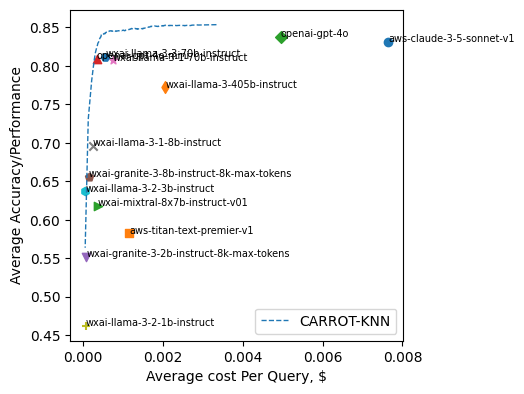

In [73]:
models = data['models']
fig, ax = plt.subplots(1, 1, figsize = (4.3, 4.3))

markers = ['o', 's', 'D', '^', 'v', 'p', '*', 'x', '+', 'h', 'H', 'd', '>', 'P', '<', '|', '_', '.', ',', '1']
ax.errorbar(routing_cost, routing_perf,
            linestyle='--', linewidth=1, alpha = 1, label = 'CARROT-KNN')

for i, txt in enumerate(models):

    x, y = data['C_val'][:,i].mean(0), data['Y_val'][:,i].mean(0)
    ax.scatter([x], [y], marker = markers[i])
    ax.annotate(models[i], (x, y), size=7, horizontalalignment='left')

ax.set_xlabel('Average cost Per Query, \$')
ax.set_ylabel('Average Accuracy/Performance')
ax.legend()
plt.show()

At test time, we need to choose a combination of cost and performance from the plot above. Assume that we are happy with the performance when $c=.001$. We need to find the value of $\lambda$ that returns that cost.

In [75]:
c = .001
optimal_lamb = lamb_range[np.abs(routing_cost-c).argmin()]

Now, we can start routing queries for the test set:

In [80]:
test_risk = (1-optimal_lamb)*data['Y_hat_test'] - optimal_lamb*data['C_hat_test']
chosen_models = test_risk.argmax(1)

Checking the frequency we choose each model

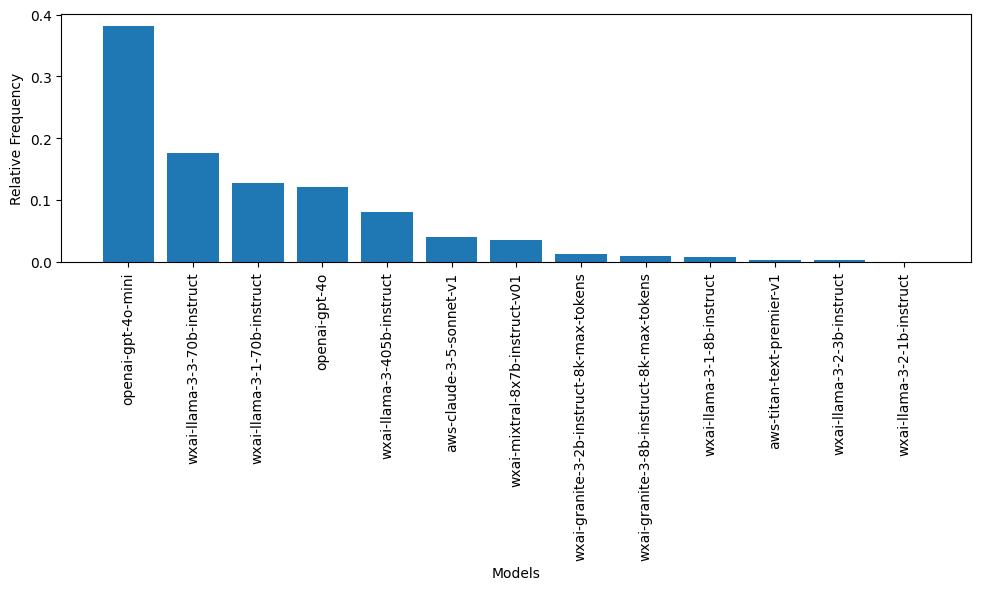

In [87]:
freq = Counter([models[i] for i in chosen_models])

# Sort the items by frequency (highest first)
sorted_items = sorted(freq.items(), key=lambda x: x[1], reverse=True)
strings, counts = zip(*sorted_items)
counts /= np.sum(counts)

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(strings, counts)
plt.xlabel('Models')
plt.ylabel('Relative Frequency')
plt.xticks(rotation=90)  # Rotate labels if needed
plt.tight_layout()  # Adjust layout to ensure labels fit
plt.show()

Checking performance in the test set

In [92]:
router_perf = np.mean([y[chosen_models[i]] for i,y in enumerate(data['Y_test'])])
router_cost = np.mean([c[chosen_models[i]] for i,c in enumerate(data['C_test'])])

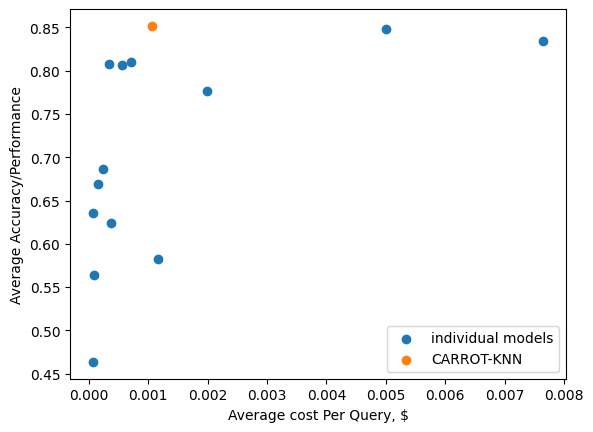

In [102]:
plt.scatter(data['C_test'].mean(0),data['Y_test'].mean(0),label='individual models')
plt.scatter(router_cost,router_perf,label='CARROT-KNN')
plt.xlabel('Average cost Per Query, \$')
plt.ylabel('Average Accuracy/Performance')
plt.legend()
plt.show()